# Look at accelerometer data 

Finding Zero velocity times by rail axis acceleration noise levels, making summary statistics for the noise levels across the whole day files.  Spot check graphs to see what works

In [1]:
#Standard Header used on the projects

#first the major packages used for math and graphing
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import scipy.special as sp

#Custome graph format style sheet
#plt.style.use('Prospectus.mplstyle')

#If being run by a seperate file, use the seperate file's graph format and saving paramaeters
#otherwise set what is needed
if not 'Saving' in locals():
    Saving = False
if not 'Titles' in locals():
    Titles = True
if not 'Ledgends' in locals():
    Ledgends = True
if not 'FFormat' in locals():
    FFormat = '.png'

#Standard cycle to make black and white images and dashed and line styles
default_cycler = (cycler('color', ['0.00', '0.40', '0.60', '0.70']) + cycler(linestyle=['-', '--', ':', '-.']))
plt.rc('axes', prop_cycle=default_cycler)
my_cmap = plt.get_cmap('gray')

In [2]:
#Extra Headers:
import os as os
import pywt as py
import statistics as st
import os as os
import random
import multiprocessing
from joblib import Parallel, delayed
import platform

from time import time as ti

In [3]:
import CoreFunctions as cf
from skimage.restoration import denoise_wavelet

## Choosing Platform
Working is beinging conducted on several computers, and author needs to be able to run code on all without rewriting..  This segment of determines which computer is being used, and sets the directories accordingly.

In [4]:
HostName = platform.node()

if HostName == "Server":
    Computer = "Desktop"   
elif HostName[-6:] == 'wm.edu':
    Computer = "SciClone"
elif HostName == "SchoolLaptop":
    Computer = "LinLap"
elif HostName == "WTC-TAB-512":
    Computer = "PortLap"
else:
    Computer = "WinLap"

In [5]:
if Computer == "SciClone":
    location = '/sciclone/home20/dchendrickson01/image/'
elif Computer == "WinLap":
    location = 'C:\\Data\\'
elif Computer == "Desktop":
    location = "E:\\Backups\\Dan\\CraneData\\"
elif Computer == "LinLap":
    location = '/home/dan/Output/'
elif Computer == 'PortLap':
    location = 'C:\\users\\dhendrickson\\Desktop\\AccelData\\'

In [6]:
if Computer ==  "SciClone":
    rootfolder = '/sciclone/home20/dchendrickson01/'
    folder = '/sciclone/scr10/dchendrickson01/Recordings2/'
elif Computer == "Desktop":
    rootfolder = location
    folder = rootfolder + "Recordings2\\"
elif Computer =="WinLap":
    rootfolder = location
    folder = rootfolder + "Recordings2\\"   
elif Computer == "LinLap":
    rootfolder = '/home/dan/Data/'
    folder = rootfolder + 'Recordings2/'
elif Computer =='PortLap':
    rootfolder = location 
    folder = rootfolder + 'Recordings2\\'

In [7]:
files = os.listdir(folder)
files=files[39:41]

In [8]:
Saving = False
location = folder
Titles = True
Ledgends = True

f = 0


In [9]:
def RollingStdDev(RawData, SmoothData, RollSize = 25):
    StdDevs = []
    for i in range(RollSize):
        Diffs = RawData[0:i+1]-SmoothData[0:i+1]
        Sqs = Diffs * Diffs
        Var = sum(Sqs) / (i+1)
        StdDev = np.sqrt(Var)
        StdDevs.append(StdDev)
    for i in range(len(RawData)-RollSize-1):
        j = i + RollSize
        Diffs = RawData[i:j]-SmoothData[i:j]
        Sqs = Diffs * Diffs
        Var = sum(Sqs) / RollSize
        StdDev = np.sqrt(Var)
        StdDevs.append(StdDev)  
    
    return StdDevs

def RollingSum(Data, Length = 100):
    RollSumStdDev = []
    for i in range(Length):
        RollSumStdDev.append(sum(Data[0:i+1]))
    for i in range(len(Data) - Length):
        RollSumStdDev.append(sum(Data[i:i+Length]))
    return RollSumStdDev

def SquelchPattern(DataSet, StallRange = 5000, SquelchLevel = 0.0086):
    SquelchSignal = np.ones(len(DataSet))

    for i in range(len(DataSet)-2*StallRange):
        if np.average(DataSet[i:i+StallRange]) < SquelchLevel:
            SquelchSignal[i+StallRange]=0

    return SquelchSignal

def getVelocity(Acceleration, Timestamps = 0.003, Squelch = [], corrected = 0):
    velocity = np.zeros(len(Acceleration))
    
    Acceleration -= np.average(Acceleration)
    
    if len(Timestamps) == 1:
        dTime = np.ones(len(Acceleration),dtype=float) * Timestamps
    elif len(Timestamps) == len(Acceleration):
        dTime = np.zeros(len(Timestamps), dtype=float)
        dTime[0]=1
        for i in range(len(Timestamps)-1):
            j = i+1
            if Timestamps[j] > Timestamps[i]:
                dTime[j]=Timestamps[j]-Timestamps[i]
            else:
                dTime[j]=Timestamps[j]-Timestamps[i]+10000.0
        dTime /= 10000.0

    velocity[0] = Acceleration[0] * (dTime[0])

    for i in range(len(Acceleration)-1):
        j = i + 1
        if corrected ==2:
            if Squelch[j]==0:
                velocity[j]=0
            else:
                velocity[j] = velocity[i] + Acceleration[j] * dTime[j]                
        else:
            velocity[j] = velocity[i] + Acceleration[j] * dTime[j]

    if corrected == 1:
        PointVairance = velocity[-1:] / len(velocity)
        for i in range(len(velocity)):
            velocity[i] -=  PointVairance * i
    
    velocity *= 9.81

    return velocity

def MakeDTs(Seconds, Miliseconds):
    dts = np.zeros(len(Miliseconds), dtype=float)
    dts[0]=1
    for i in range(len(MiliSeconds)-1):
        j = i+1
        if Seconds[j]==Seconds[i]:
            dts[j]=Miliseconds[j]-Miliseconds[i]
        else:
            dts[j]=Miliseconds[j]-Miliseconds[i]+1000
    dts /= 10000
    return dts


In [10]:
#Smooth = cf.Smoothing(ODataSet[:,3],2) #,50)
def DeviationVelocity(file):
    if file[-3:] =='csv':
        ODataSet = np.genfromtxt(open(folder+file,'r'), delimiter=',',skip_header=0,missing_values=0,invalid_raise=False)
        SmoothX = denoise_wavelet(ODataSet[:,3], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        SmoothX -= np.average(SmoothX)
        StdDevsX = RollingStdDev(ODataSet[:,3],SmoothX)
        StdDevsX.append(0)
        StdDevsX = np.asarray(StdDevsX)
        SmoothDevX = denoise_wavelet(StdDevsX, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        SquelchSignal = SquelchPattern(SmoothDevX, 1500, 0.04)
        #Velocity = getVelocity(ODataSet[:,3], ODataSet[:,2],SquelchSignal, 2)
        #Velocity = np.asarray(Velocity)
        return [SquelchSignal,SmoothX,ODataSet[:,4]]
    else:
        pass

In [11]:
#files = fi2

In [12]:
# Maunally chooseing before and after tamping for same track

files = ['230103 recording3.csv','230104 recording3.csv','230105 recording3.csv','230106 recording3.csv'] ,
         '230103 recording4.csv','230104 recording4.csv','230105 recording4.csv','230106 recording4.csv']

In [13]:
LoopFiles = 4
loops = int(len(files) / LoopFiles) 
if len(files)%LoopFiles != 0:
    loops += 1

In [14]:

SquelchSignal = []
RawData=[]

st = ti()

In [15]:
for k in range(loops):
    if k == loops -1:
        tfiles = files[k*LoopFiles:]
    else:
        tfiles = files[k*LoopFiles:(k+1)*LoopFiles]
    Results = Parallel(n_jobs=LoopFiles)(delayed(DeviationVelocity)(file) for file in tfiles)
    
    for i in range(len(Results)):       
        SquelchSignal.append(Results[i][0])
        RawData.append(Results[i][1])
    
    print(k, np.shape(Results), (ti()-st)/60.0)
    


0 (4, 6) 8.817647683620454


/sciclone/home20/dchendrickson01/.conda/envs/simple/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [16]:
#Cleaner=(np.linspace(0,1,len(Velocities[3])))*np.max(Velocities[3])
#Velocities[3] /= Cleaner

In [17]:
f=2

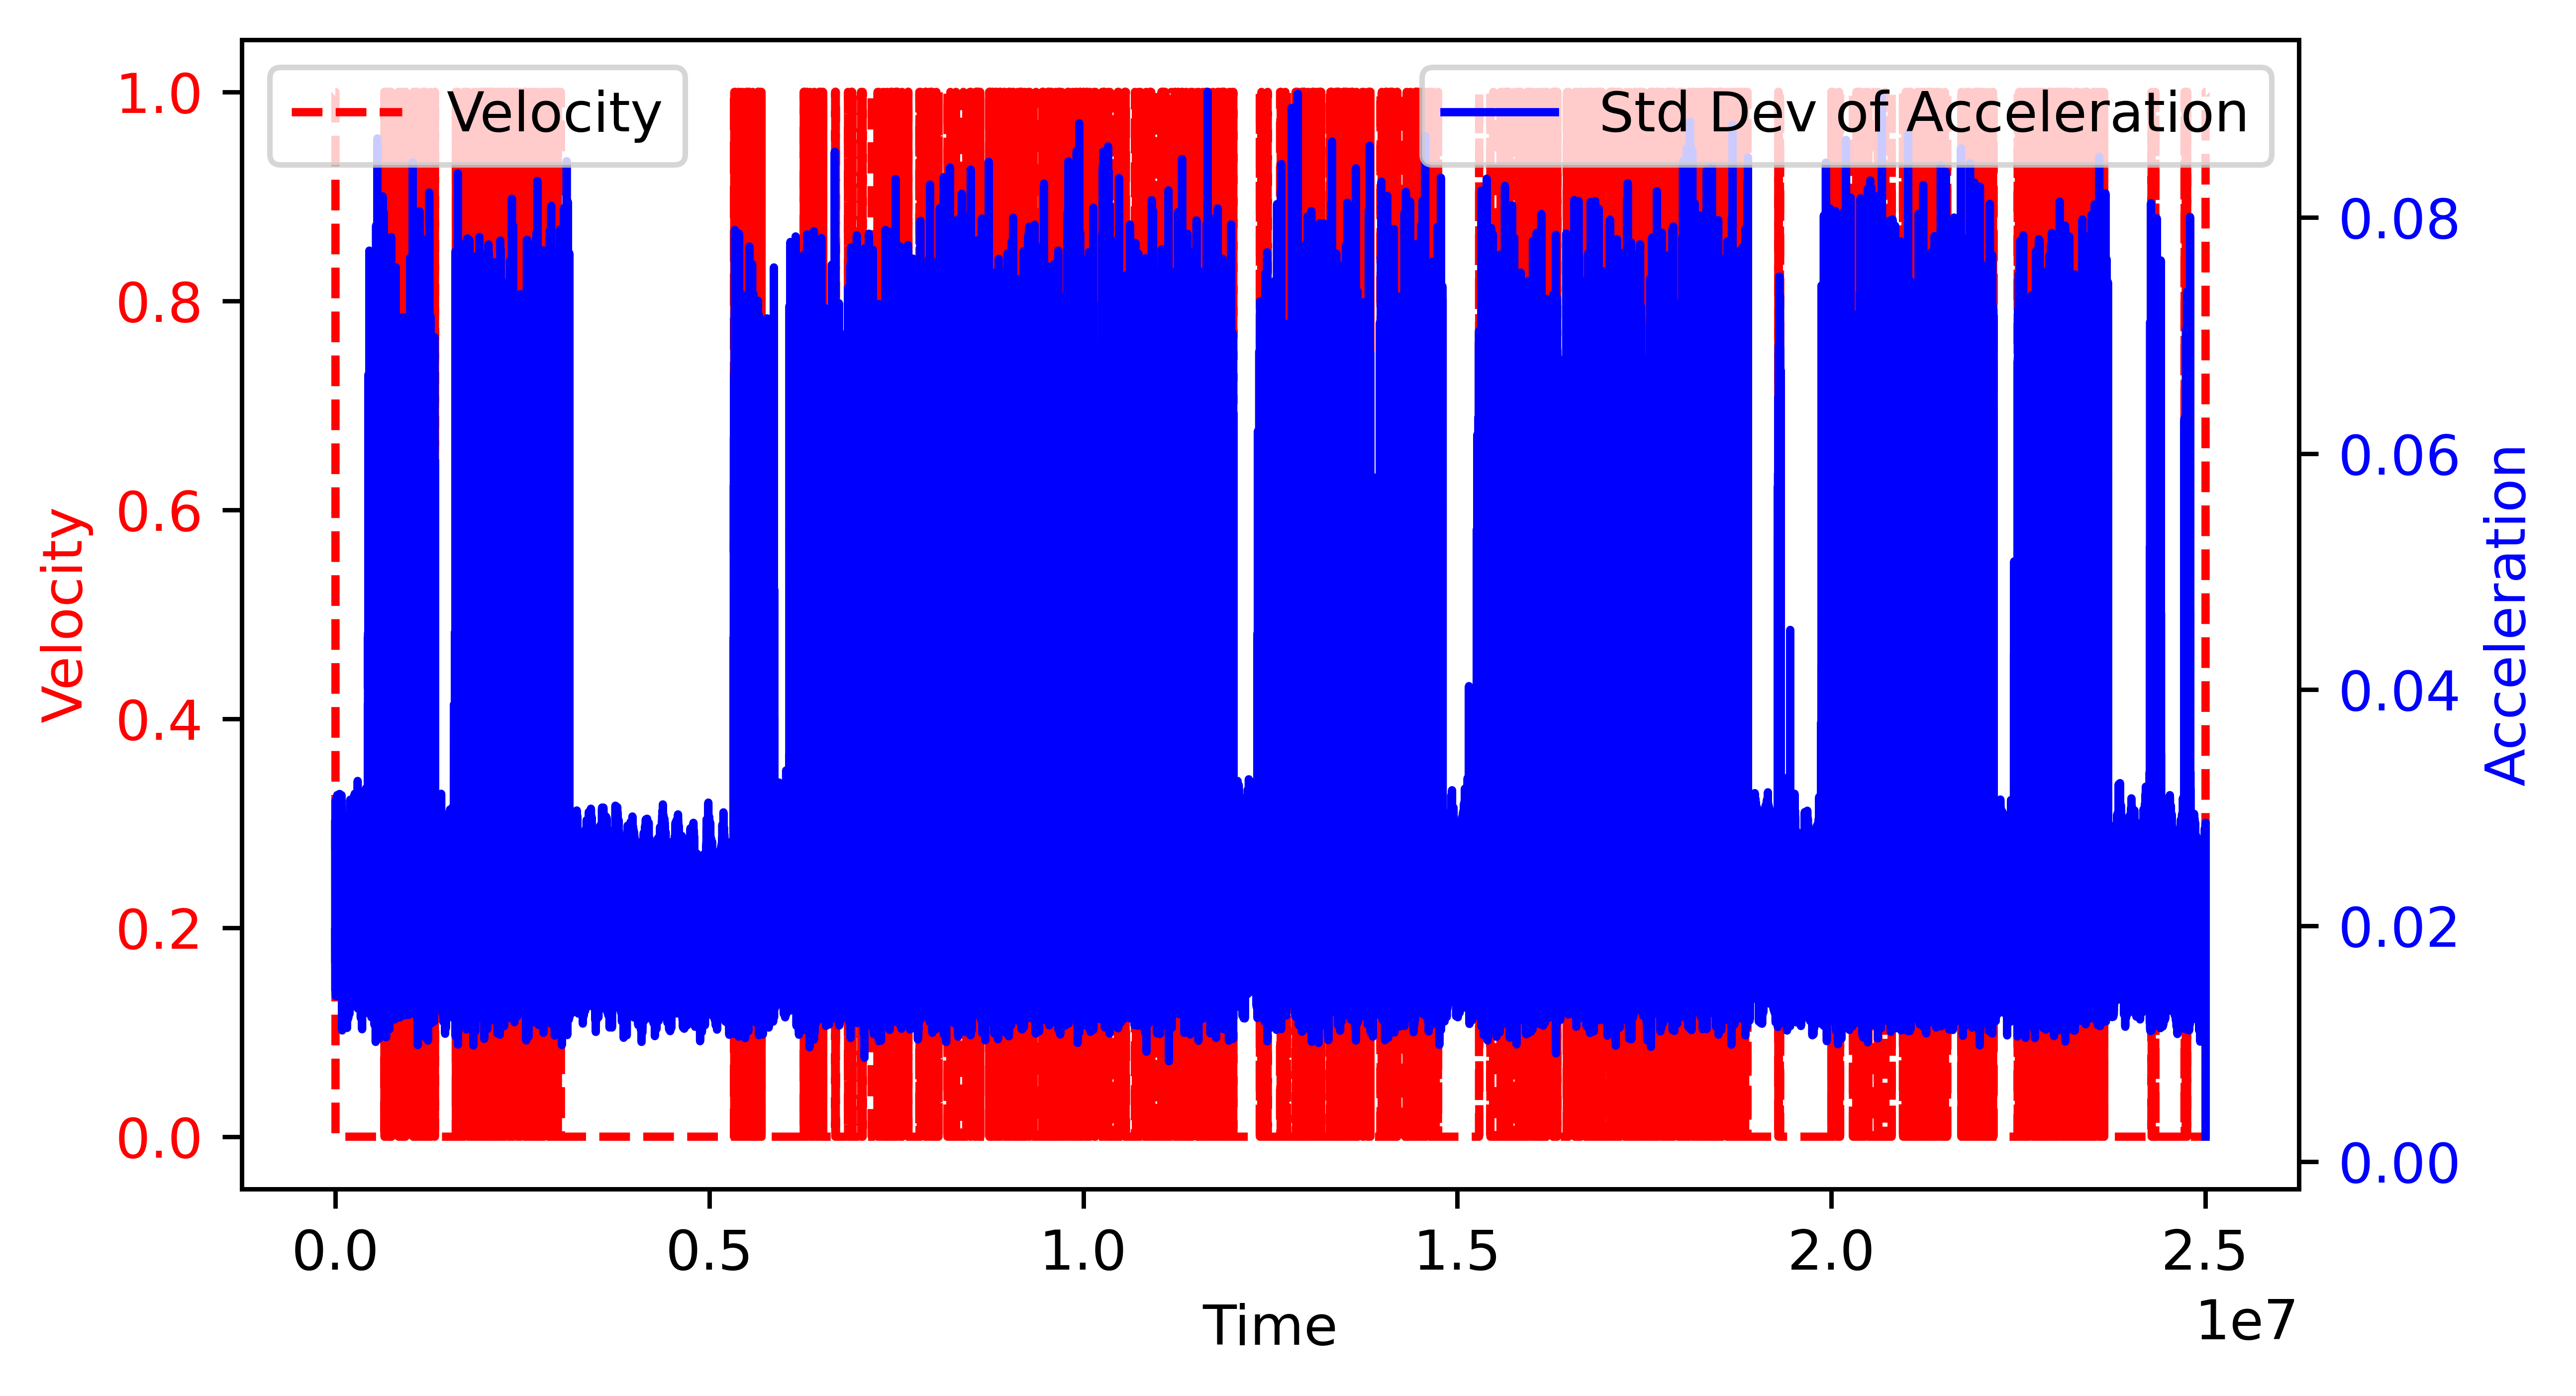

In [18]:
fig, ax1 = plt.subplots(figsize=(6.67,3.75),dpi=800,linewidth=0.5) 

PlotLength = min(len(SquelchSignal[f]), len(RawData[f]))
v = SquelchSignal[f][:PlotLength]
sd = RawData[f][:PlotLength]

ax1.set_xlabel('Time') 
ax1.set_ylabel('Squelch', color = 'red') 
ax1.plot(range(PlotLength), v, color = 'red', linestyle = 'dashed', label='Velocity' )
ax1.tick_params(axis ='y', labelcolor = 'red') 
#plt.ylim(-6,6)
legend_1 = ax1.legend(loc=2)
legend_1.remove()

# Adding Twin Axes

ax2 = ax1.twinx() 

ax2.set_ylabel('Y Signal', color = 'blue') 
ax2.plot(range(PlotLength), sd, color = 'blue', label='Acceleration') 
ax2.tick_params(axis ='y', labelcolor = 'blue') 
#plt.ylim(0.0,0.6)
ax2.legend(loc=1)
ax2.add_artist(legend_1)
# Show plot

plt.show()

In [19]:
def SepreateMovements(SquelchSignal, RawData):
    Moves=[]
    Move = []
    for j in range(len(SquelchSignal)-1):
        if SquelchSignal[j] == 1:
            Move.append(RawData[j])
            if SquelchSignal[j+1] == 0:
                Move = np.matrix(Move)
                Moves.append(Move)
                Move = []
    Moves.append(Move)
    return Moves
    

In [20]:
Movements = Parallel(n_jobs=LoopFiles)(delayed(SepreateMovements)(SquelchSignal[i], RawData[i])
                                       for i in range(len(SquelchSignal)))

In [21]:
Moves=[]
for Groups in Movements:
    for Move in Groups:
        Moves.append(Move)

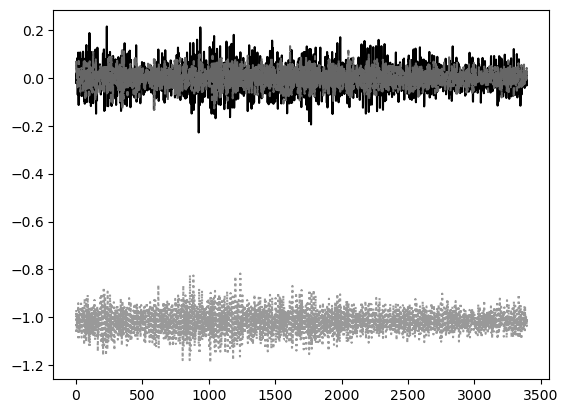

In [23]:
MoveNum = 1007
fig = plt.figure()
plt.plot(Moves[MoveNum], label='y')

plt.show()

In [24]:
Xmoves = []

for move in Moves:
    g = np.shape(move)[0]
    if g > 1000:
        ymove = []
        move = np.matrix(move)
        for i in range(g):
            ymove.append(move[i,0])
        Xmoves.append(ymove)


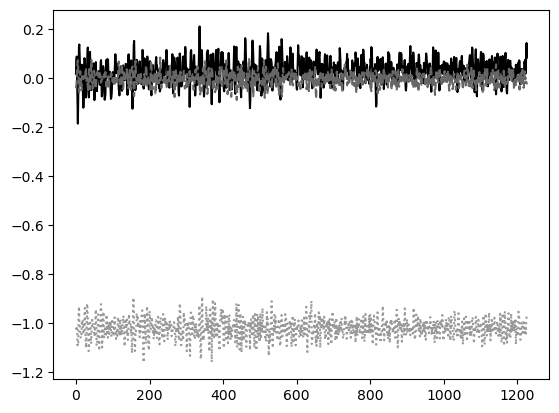

In [25]:
fig = plt.figure()
plt.plot(Ymoves[MoveNum], label='y')
plt.show()

In [30]:
del SquelchSignal
del RawData

In [34]:
maxLength = 4000
Xmoves2=[]
for move in Xmoves:
    if len(move)> maxLength: 
        Xmoves2.append(move[:int(len(move)/2)])
        Xmoves2.append(move[int(len(move)/2):])
    else:
        Xmoves2.append(move)
Xmoves = []
for move in Xmoves2:
    if len(move)> maxLength: 
        Xmoves.append(move[:int(len(move)/2)])
        Xmoves.append(move[int(len(move)/2):])
    else:
        Xmoves.append(move)
        
del Xmoves2

In [35]:
maxLength = 0
for move in Xmoves:
    if len(move) > maxLength: maxLength = len(move)
maxLength

3997

In [36]:
SplitRatio = 0.9
Split = int(SplitRatio * len(Xmoves))
Split

1917

In [37]:


XMoveMatrix = np.zeros((len(Xmoves), maxLength),dtype=float)
for i in range(len(Xmoves)):
    for j in range(len(Xmoves[i])):
        XMoveMatrix[i,j] = Xmoves[i][j]
        

In [38]:
Train_data = XMoveMatrix[-Split:]
Test_data = XMoveMatrix[:-Split]

In [39]:
np.shape(Train_data)

(1917, 3997)

## LSTM Self Supervised
#https://medium.com/@jetnew/anomaly-detection-of-time-series-data-e0cb6b382e33

In [ ]:
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.models import Sequential

class LSTM_Autoencoder:
  def __init__(self, optimizer='adam', loss='mse'):
    self.optimizer = optimizer
    self.loss = loss
    self.n_features = 1
    
  def build_model(self):
    timesteps = self.timesteps
    n_features = self.n_features
    model = Sequential()
    
    # Encoder
    model.add(LSTM(timesteps, activation='relu', input_shape=(None, n_features), return_sequences=True))
    model.add(LSTM(16, activation='relu', return_sequences=True))
    model.add(LSTM(1, activation='relu'))
    model.add(RepeatVector(timesteps))
    
    # Decoder
    model.add(LSTM(timesteps, activation='relu', return_sequences=True))
    model.add(LSTM(16, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(n_features)))
    
    model.compile(optimizer=self.optimizer, loss=self.loss)
    model.summary()
    self.model = model
    
  def fit(self, X, epochs=3, batch_size=32):
    self.timesteps = X.shape[1]
    self.build_model()
    
    input_X = np.expand_dims(X, axis=2)
    self.model.fit(input_X, input_X, epochs=epochs, batch_size=batch_size)
    
  def predict(self, X):
    input_X = np.expand_dims(X, axis=2)
    output_X = self.model.predict(input_X)
    reconstruction = np.squeeze(output_X)
    return np.linalg.norm(X - reconstruction, axis=-1)
  
  def plot(self, scores, timeseries, threshold=0.95):
    sorted_scores = sorted(scores)
    threshold_score = sorted_scores[round(len(scores) * threshold)]
    
    plt.title("Reconstruction Error")
    plt.plot(scores)
    plt.plot([threshold_score]*len(scores), c='r')
    plt.show()
    
    anomalous = np.where(scores > threshold_score)
    normal = np.where(scores <= threshold_score)
    
    plt.title("Anomalies")
    plt.scatter(normal, timeseries[normal][:,-1], s=3)
    plt.scatter(anomalous, timeseries[anomalous][:,-1], s=5, c='r')
    plt.show()
    
lstm_autoencoder = LSTM_Autoencoder(optimizer='adam', loss='mse')
lstm_autoencoder.fit(Train_data, epochs=3, batch_size=32)
scores = lstm_autoencoder.predict(Test_data)
lstm_autoencoder.plot(scores, Test_data, threshold=0.95)

2023-04-01 20:10:38.530602: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 20:10:46.943979: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 20:10:46.950714: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 3997)        63936012  
                                                                 
 lstm_1 (LSTM)               (None, None, 16)          256896    
                                                                 
 lstm_2 (LSTM)               (None, 1)                 72        
                                                                 
 repeat_vector (RepeatVector  (None, 3997, 1)          0         
 )                                                               
                                                                 
 lstm_3 (LSTM)               (None, 3997, 3997)        63936012  
                                                                 
 lstm_4 (LSTM)               (None, 3997, 16)          256896    
                                                        

In [ ]:
#give error and stop code on run all
adsfasdfasdfasdfasdfasdfasdfasdf

# Try Others

## iForest 
Requires data in Pandas data frames

https://towardsdatascience.com/unsupervised-anomaly-detection-in-python-f2e61be17c2b

In [ ]:
from pycaret.anomaly import *


In [ ]:
Move_dict = dict(Xmoves)
df_Move = pd.DataFrame.from_dict(Move_dict, oreint='index')

In [ ]:
df_train = df_Move[:-Split]
df_unseen = df_Move[-Split:]

In [ ]:
anom = setup(data = df_train, silent = True)


In [ ]:
anom_model = create_model(model = 'iforest', fraction = 0.05)


In [ ]:
results = assign_model(anom_model)

In [ ]:
plot_model(anom_model, plot = 'tsne')

In [ ]:
plot_model(anom_model, plot = 'umap')

In [ ]:
anom_model.predict(df_unseen)

In [ ]:
anom_model.predict_proba(df_unseen)


In [ ]:
anom_model.decision_function(df_unseen)


## Heirarchal clustering
https://medium.com/@jetnew/anomaly-detection-of-time-series-data-e0cb6b382e33

In [ ]:
from sklearn.cluster import AgglomerativeClustering

clusters = 3
y_pred = AgglomerativeClustering(n_clusters=clusters).fit_predict(Test_data)


from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

clusters=5
cls = linkage(Test_data, method='ward')
y_pred = fcluster(cls, t=clusters, criterion='maxclust')

dendrogram(cls)
plt.show()

## Multiple Techniques
https://www.kaggle.com/code/victorambonati/unsupervised-anomaly-detection

In [ ]:
# libraries
#%matplotlib notebook

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [ ]:
# some function for later

# return Series of distance between each point and his distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

# train markov model to get transition matrix
def getTransitionMatrix (df):
	df = np.array(df)
	model = msm.estimate_markov_model(df, 1)
	return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

In [ ]:
#In 13
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(Train_data) for i in n_cluster]
scores = [kmeans[i].score(Train_data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [ ]:
# Not clear for me, I choose 15 centroids arbitrarily and add these data to the central dataframe
df['cluster'] = kmeans[14].predict(Train_data)
df['principal_feature1'] = Train_data[0]
df['principal_feature2'] = Train_data[1]
df['cluster'].value_counts()